In [ ]:
VER=3

# Import library 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import PIL
import PIL.Image

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

import pathlib
import os
import warnings
warnings.filterwarnings('ignore')

# Processing

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/hackathon/plant-pathology-2020-fgvc7/train.csv", index_col=0)
print(df.shape)
df.head()

(1821, 4)


,healthy,multiple_diseases,rust,scab
image_id,,,,
Train_0,0,0,0,1
Train_1,0,1,0,0
Train_2,1,0,0,0
Train_3,0,0,1,0
Train_4,1,0,0,0


In [ ]:
import shutil
from shutil import copyfile

if os.path.exists('temp'):
    shutil.rmtree('temp')

os.mkdir('temp')
os.mkdir('temp/images')
os.mkdir('temp/images/healthy')
os.mkdir('temp/images/multiple_diseases')
os.mkdir('temp/images/rust')
os.mkdir('temp/images/scab')

In [ ]:
SOURCE = '/content/drive/MyDrive/hackathon/plant-pathology-2020-fgvc7/images'

SPLIT_DIR = 'temp/images/'

# copy images to train directory
for index, data in df.iterrows():
    label = df.columns[np.argmax(data)]
    filepath = os.path.join(SOURCE, index + ".jpg")
    destination = os.path.join(SPLIT_DIR, label, index + ".jpg")
    copyfile(filepath, destination)

In [ ]:
for subdir in os.listdir(SPLIT_DIR):
    print(subdir, len(os.listdir(os.path.join(SPLIT_DIR, subdir))))

multiple_diseases 91
scab 592
rust 622
healthy 516


In [ ]:
#define parameters
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
#create training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    'temp/images',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 1821 files belonging to 4 classes.
Using 1457 files for training.


In [ ]:
#create validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
    'temp/images',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 1821 files belonging to 4 classes.
Using 364 files for validation.


In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(num_classes, class_names)

4 ['healthy', 'multiple_diseases', 'rust', 'scab']


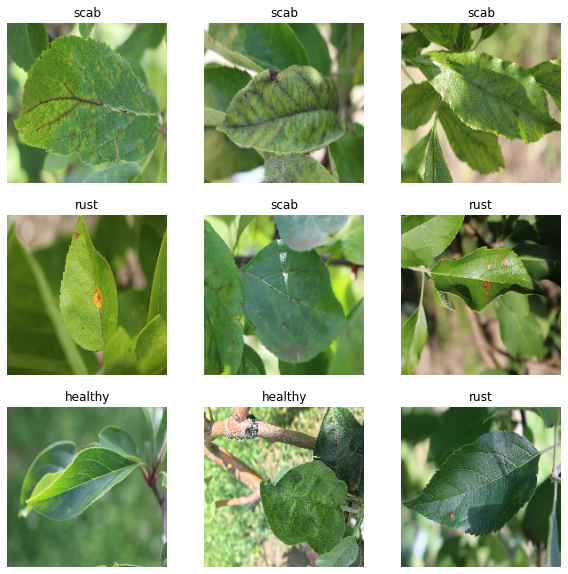

In [ ]:
#Visualize data

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[list(labels[i]).index(1)])
        plt.axis("off")

plt.savefig('/content/drive/MyDrive/hackathon/plant-pathology-2020-fgvc7/test.png')

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32, 4)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

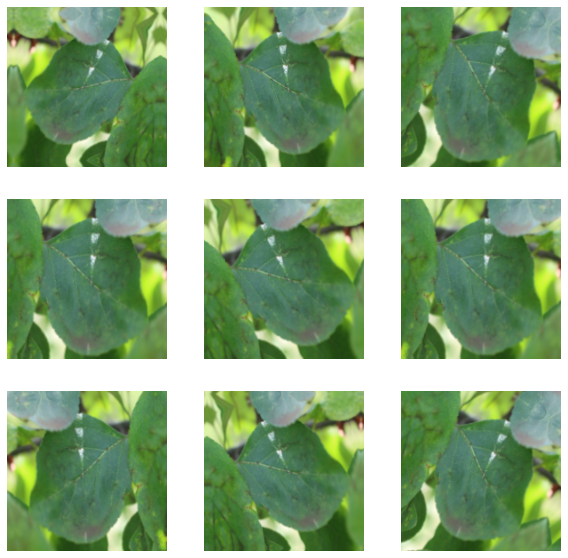

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Model Training (don't run again)

In [ ]:
model = tf.keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  monitor="val_loss",
                                                  verbose=2,
                                                  mode="auto")
checkpoint = tf.keras.callbacks.ModelCheckpoint(f"/content/drive/MyDrive/hackathon/plant-pathology-2020-fgvc7/best_v{VER}.h5", 
                                                monitor="val_loss",
                                                mode="auto",
                                                verbose=2,
                                                save_best_only=True)
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()
plt.savefig('/content/drive/MyDrive/hackathon/plant-pathology-2020-fgvc7/summary.png')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = 200

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping,checkpoint]
)

Epoch 1/200
44/46 [===========================>..] - ETA: 0s - loss: 1.2692 - accuracy: 0.3388
Epoch 00001: val_loss improved from inf to 1.29160, saving model to /content/drive/MyDrive/hackathon/plant-pathology-2020-fgvc7/best_v3.h5
46/46 [==============================] - 14s 91ms/step - loss: 1.2650 - accuracy: 0.3439 - val_loss: 1.2916 - val_accuracy: 0.3242
Epoch 2/200
45/46 [============================>.] - ETA: 0s - loss: 1.2307 - accuracy: 0.3579
Epoch 00002: val_loss improved from 1.29160 to 1.22545, saving model to /content/drive/MyDrive/hackathon/plant-pathology-2020-fgvc7/best_v3.h5
46/46 [==============================] - 1s 32ms/step - loss: 1.2315 - accuracy: 0.3610 - val_loss: 1.2254 - val_accuracy: 0.4286
Epoch 3/200
46/46 [==============================] - ETA: 0s - loss: 1.1773 - accuracy: 0.4097
Epoch 00003: val_loss improved from 1.22545 to 1.17640, saving model to /content/drive/MyDrive/hackathon/plant-pathology-2020-fgvc7/best_v3.h5
46/46 [======================

In [ ]:
# VER=2
# model.save_weights(f'/content/drive/MyDrive/hackathon/plant-pathology-2020-fgvc7/model_v{VER}.h5')
# model.save(f'/content/drive/MyDrive/hackathon/plant-pathology-2020-fgvc7/weight_v{VER}model.h5')

In [ ]:
# model.save_weights(f'/content/drive/MyDrive/hackathon/plant-pathology-2020-fgvc7/weight_v{VER}.h5')
# model.save(f'/content/drive/MyDrive/hackathon/plant-pathology-2020-fgvc7/model_v{VER}.h5')

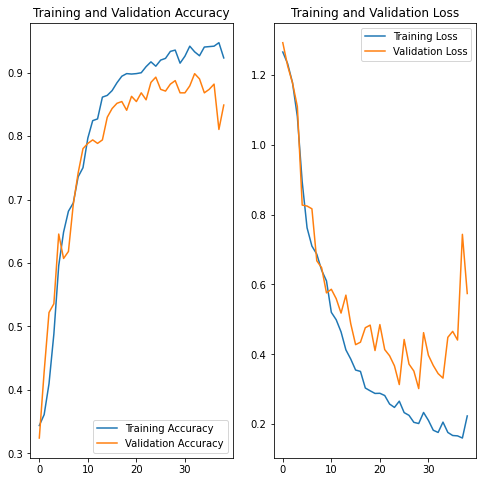

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = len(acc)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('/content/drive/MyDrive/hackathon/plant-pathology-2020-fgvc7/result.png')
plt.show()

In [ ]:
from keras_preprocessing import image

test_set = pd.read_csv("/content/drive/MyDrive/hackathon/plant-pathology-2020-fgvc7/test.csv", index_col=0)

X_test = []
for index, data in test_set.iterrows():
    filepath = os.path.join(SOURCE, index + ".jpg")
    img = image.load_img(filepath, target_size=(img_height, img_width))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    X_test.append(x)
    
X_test = np.vstack(X_test)

In [ ]:
filepath = '/content/drive/MyDrive/hackathon/plant-pathology-2020-fgvc7/images/Test_1817.jpg'
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))

In [ ]:
predictions = model.predict(X_test, batch_size= 10)
score = tf.nn.softmax(predictions)
score = np.array(score)
df_out = pd.concat([test_set.reset_index(), pd.DataFrame(score, columns = class_names)], axis=1).set_index("image_id")
df_out.to_csv('submission.csv')
df_out.head()

In [ ]:
score

In [ ]:
predicted = np.argmax(score,axis=1)
predicted

In [ ]:
predicted[:10]

In [ ]:
test_set[:10]

In [ ]:
health_cond={0:'healthy',1: 'multiple_diseases',2: 'rust',3: 'scab'}

for i in range(10):
  filepath = f'/content/drive/MyDrive/hackathon/plant-pathology-2020-fgvc7/images/Test_{i}.jpg'
  img = image.load_img(filepath, target_size=(img_height, img_width))
  plt.imshow(img)
  print(health_cond.get(predicted[i]))


In [ ]:
for i in range(5):
  filepath = f'/content/drive/MyDrive/hackathon/plant-pathology-2020-fgvc7/images/Test_{i}.jpg'
  img = image.load_img(filepath, target_size=(img_height, img_width))
  plt.imshow(img)
  print(health_cond.get(predicted[i]))

# Load Model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
VER=2
model_path=f"/content/drive/MyDrive/hackathon/plant-pathology-2020-fgvc7/best_v{VER}.h5"
model = tf.keras.models.load_model(model_path)

In [ ]:
# loss, acc = model.evaluate(val_ds,verbose=1)
# print('Accuracy: {:5.2f}%'.format(100 * acc))

# Model Prediction

In [ ]:
import os
image_list=[]
for i in os.listdir('/content/drive/MyDrive/hackathon/testing/image'):
  image_list.append(i.split('.')[0])

import pandas as pd 
df = pd.DataFrame(image_list)
df.columns=['image_id']
df.to_csv('/content/drive/MyDrive/hackathon/testing/testing.csv')

In [ ]:
from keras_preprocessing import image
SOURCE = '/content/drive/MyDrive/hackathon/testing/image'
test_set = pd.read_csv("/content/drive/MyDrive/hackathon/testing/testing.csv", index_col=0)

img_height = 180
img_width = 180

X_test = []
for index in test_set.image_id:
#for index, data in test_set.iterrows():
    filepath = SOURCE+'/'+index+ '.jpg'
    #filepath = os.path.join(SOURCE, index + ".jpg")
    img = image.load_img(filepath, target_size=(img_height, img_width))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    X_test.append(x)
    
X_test = np.vstack(X_test)

['healthy', 'multiple_diseases', 'rust', 'scab']
[[0.46621177 0.17749508 0.17681047 0.17948265]]


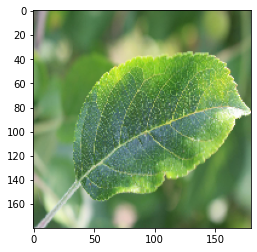

In [ ]:
os.listdir('/content/drive/MyDrive/hackathon/testing/image')[0]
filepath = '/content/drive/MyDrive/hackathon/testing/image/'+os.listdir('/content/drive/MyDrive/hackathon/testing/image')[0]
class_names = ['healthy', 'multiple_diseases', 'rust', 'scab']
num_classes = len(class_names)
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))

In [ ]:
predictions = model.predict(X_test, batch_size= 10)
score = tf.nn.softmax(predictions)
score = np.array(score)
predicted = np.argmax(score,axis=1)
health_cond={0:'healthy',1: 'multiple_diseases',2: 'rust',3: 'scab'}
cond=[]
for i in predicted.tolist():
  var=health_cond.get(int(i))
  cond.append(var)

df_out = pd.concat([test_set.reset_index(), pd.DataFrame(score, columns = class_names)], axis=1).set_index("image_id")
df_out['cond']=cond
df_out.to_csv('/content/drive/MyDrive/hackathon/testing/submission.csv')
df_out.head()

,index,healthy,multiple_diseases,rust,scab,cond
image_id,,,,,,
Train_1760,0,0.466212,0.177495,0.176810,0.179483,healthy
Train_1759,1,0.178176,0.178634,0.176328,0.466862,scab
Train_1758,2,0.190876,0.187810,0.180546,0.440769,scab
Train_1757,3,0.175687,0.178449,0.470176,0.175687,rust
Train_1756,4,0.175272,0.176442,0.175287,0.473000,scab


In [ ]:
# sample_='Train_1749'
# filepath = f'/content/drive/MyDrive/hackathon/testing/image/{sample_}.jpg'
# img = image.load_img(filepath, target_size=(img_height, img_width))
# plt.imshow(img)
# df_out.loc[{sample}].cond

In [ ]:
def check_cond(sample_):
  #sample_='Train_1749'
  filepath = f'/content/drive/MyDrive/hackathon/testing/image/{sample_}.jpg'
  img = image.load_img(filepath, target_size=(img_height, img_width))
  plt.imshow(img)
  plt.title([df_out.loc[{sample_}].cond])
  #return df_out.loc[{sample_}].cond

# processing 

In [ ]:
def check_cond(sample_):
  #sample_='Train_1749'
  filepath = f'/content/drive/MyDrive/hackathon/testing/image/{sample_}.jpg'
  img = image.load_img(filepath, target_size=(img_height, img_width))
  plt.imshow(img)
  plt.title([df_out.loc[{sample_}].cond])
  #return df_out.loc[{sample_}].cond

In [ ]:
import pandas as pd
df_out=pd.read_csv('/content/drive/MyDrive/hackathon/testing/submission.csv')

# DEMO

In [ ]:
df_out.head()

,index,healthy,multiple_diseases,rust,scab,cond
image_id,,,,,,
Train_1760,0,0.466212,0.177495,0.176810,0.179483,healthy
Train_1759,1,0.178176,0.178634,0.176328,0.466862,scab
Train_1758,2,0.190876,0.187810,0.180546,0.440769,scab
Train_1757,3,0.175687,0.178449,0.470176,0.175687,rust
Train_1756,4,0.175272,0.176442,0.175287,0.473000,scab


In [ ]:
len(df_out) #20 images

20

In [ ]:
check_cond('Train_1760')

In [ ]:
check_cond('Train_1759')

In [ ]:
check_cond('Train_1757')

In [ ]:
check_cond('Train_1700')

# drop

In [ ]:
list(zip(df_out.index.tolist(),df_out.cond.tolist())

[('Train_1749', 'rust'),
 ('Train_1750', 'healthy'),
 ('Train_1751', 'scab'),
 ('Train_1752', 'rust'),
 ('Train_1753', 'rust'),
 ('Train_1754', 'scab'),
 ('Train_1755', 'rust'),
 ('Train_1756', 'scab'),
 ('Train_1757', 'rust'),
 ('Train_1758', 'scab'),
 ('Train_1759', 'scab'),
 ('Train_1760', 'healthy'),
 ('Train_1704', 'scab'),
 ('Train_1702', 'scab'),
 ('Train_1703', 'scab'),
 ('Train_1698', 'healthy'),
 ('Train_1699', 'rust'),
 ('Train_1700', 'multiple_diseases'),
 ('Train_1701', 'scab'),
 ('Train_1625', 'rust')]

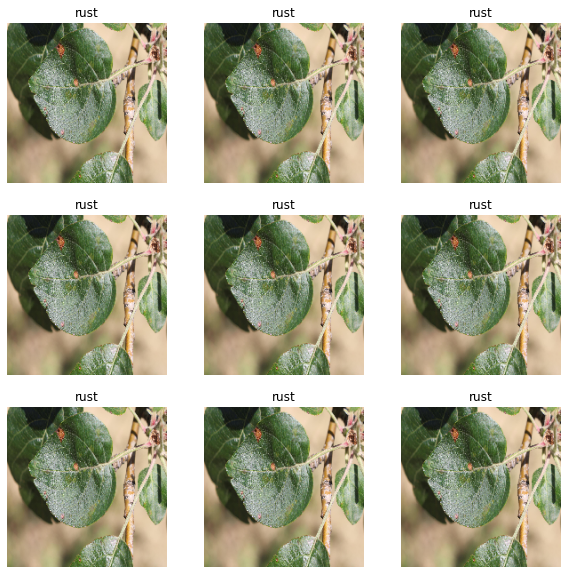

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in list(zip(df_out.index.tolist(),df_out.cond.tolist())):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    filepath = f'/content/drive/MyDrive/hackathon/testing/image/{images}.jpg'
    img = image.load_img(filepath, target_size=(img_height, img_width))
    plt.imshow(img)
    plt.title(labels)
    plt.axis("off")

In [ ]:
df_out[df_out.cond=='multiple_diseases']

,index,healthy,multiple_diseases,rust,scab,cond
image_id,,,,,,
Train_1700,15,0.258289,0.269523,0.219104,0.253085,multiple_diseases


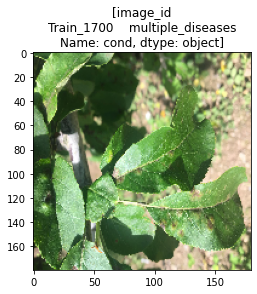

In [ ]:
import matplotlib.pyplot as plt

check_cond('Train_1760')
check_cond('Train_1759')
check_cond('Train_1757')
check_cond('Train_1700')

for x in ['Train_1760','Train_1759','Train_1757','Train_1700']:
  check_cond(x)
  plt.savefig(f'/content/drive/MyDrive/hackathon/testing/test{x}.png')